In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import os
import torch
current_folder = globals()['_dh'][0]
print(current_folder)
os.chdir(os.path.join(current_folder, '..'))

# fmt: on

from PIL import Image
import tempfile
import time
import warnings
from transformers import AutoTokenizer
import cv2
import numpy as np
import tqdm
import torch
from matplotlib import pyplot as plt
from detectron2.utils.visualizer import Visualizer
from projects.HIPIE.demo_lib.demo_utils import *
from scipy.ndimage import distance_transform_edt, label as ndi_label
# SAM
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor
from detectron2.data.detection_utils import read_image,convert_PIL_to_numpy

/home/kkallidromitis/universal/hipie/notebooks


In [3]:
args = Namespace()
args.config_file = 'projects/HIPIE/configs/image_joint_vit_huge_32g_pan_maskdino_ade_test.yaml'
args.opts = ['OUTPUT_DIR','outputs/test_maskdino_pan_fixed_lan']
args.task = "detection"
cfg = setup_cfg(args,'weights/vith_cloud.pth')
cfg.MODEL.CLIP.ALPHA = 0.2
cfg.MODEL.CLIP.BETA = 0.45
cfg.MODEL.PANO_TEMPERATURE_CLIP_FG = 0.01
cfg.MODEL.PANO_TEMPERATURE = 0.06

demo,model = init_demo(cfg)
args = Namespace()
args.config_file = 'projects/HIPIE/configs/image_joint_r50_pan_maskdino_parts.yaml'
args.opts = ['OUTPUT_DIR','outputs/parts']
args.task = "detection"
cfg = setup_cfg(args,'weights/r50_parts.pth')
demo_parts = VisualizationDemo(cfg)

model_type= "vit_h"
sam_checkpoint = 'weights/sam_vit_h_4b8939.pth'
sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
device = "cuda"
sam.to(device)
mask_generator = SamAutomaticMaskGenerator(sam)
predictor = SamPredictor(sam)

Some weights of the model checkpoint at projects/HIPIE/bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'bert.pooler.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'bert.pooler.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


MASK_DINO has some weights not loaded, typically these are only predication and mask heads:_IncompatibleKeys(missing_keys=['pixel_decoder.input_proj.0.0.weight', 'pixel_decoder.input_proj.1.0.weight', 'pixel_decoder.input_proj.2.0.weight', 'pixel_decoder.input_proj.3.0.weight', 'pixel_decoder.mask_features.0.weight', 'pixel_decoder.mask_features.0.bias', 'pixel_decoder.mask_features.1.weight', 'pixel_decoder.mask_features.1.bias', 'pixel_decoder.mask_features.3.weight', 'pixel_decoder.mask_features.3.bias', 'pixel_decoder.adapter_1.weight', 'predictor.class_embed.weight', 'predictor.class_embed.bias', 'predictor.resizer.fc.weight', 'predictor.resizer.fc.bias', 'predictor.resizer.layer_norm.weight', 'predictor.resizer.layer_norm.bias', 'predictor._bbox_embed.layers.0.weight', 'predictor._bbox_embed.layers.0.bias', 'predictor._bbox_embed.layers.1.weight', 'predictor._bbox_embed.layers.1.bias', 'predictor._bbox_embed.layers.2.weight', 'predictor._bbox_embed.layers.2.bias', 'predictor.bbox

clip.clip.ln_final.{bias, weight}
clip.clip.token_embedding.weight
clip.clip.transformer.resblocks.0.attn.out_proj.{bias, weight}
clip.clip.transformer.resblocks.0.attn.{in_proj_bias, in_proj_weight}
clip.clip.transformer.resblocks.0.ln_1.{bias, weight}
clip.clip.transformer.resblocks.0.ln_2.{bias, weight}
clip.clip.transformer.resblocks.0.mlp.c_fc.{bias, weight}
clip.clip.transformer.resblocks.0.mlp.c_proj.{bias, weight}
clip.clip.transformer.resblocks.1.attn.out_proj.{bias, weight}
clip.clip.transformer.resblocks.1.attn.{in_proj_bias, in_proj_weight}
clip.clip.transformer.resblocks.1.ln_1.{bias, weight}
clip.clip.transformer.resblocks.1.ln_2.{bias, weight}
clip.clip.transformer.resblocks.1.mlp.c_fc.{bias, weight}
clip.clip.transformer.resblocks.1.mlp.c_proj.{bias, weight}
clip.clip.transformer.resblocks.10.attn.out_proj.{bias, weight}
clip.clip.transformer.resblocks.10.attn.{in_proj_bias, in_proj_weight}
clip.clip.transformer.resblocks.10.ln_1.{bias, weight}
clip.clip.transformer.res

  detr.mask_dino.predictor.label_enc.weight


Length of coco_panoptic Categories : 133


Some weights of the model checkpoint at projects/HIPIE/bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'bert.pooler.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'bert.pooler.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


MASK_DINO has some weights not loaded, typically these are only predication and mask heads:_IncompatibleKeys(missing_keys=['pixel_decoder.mask_features.0.weight', 'pixel_decoder.mask_features.0.bias', 'pixel_decoder.mask_features.1.weight', 'pixel_decoder.mask_features.1.bias', 'pixel_decoder.mask_features.3.weight', 'pixel_decoder.mask_features.3.bias', 'pixel_decoder.adapter_1.weight', 'predictor.class_embed.weight', 'predictor.class_embed.bias', 'predictor.resizer.fc.weight', 'predictor.resizer.fc.bias', 'predictor.resizer.layer_norm.weight', 'predictor.resizer.layer_norm.bias', 'predictor._bbox_embed.layers.0.weight', 'predictor._bbox_embed.layers.0.bias', 'predictor._bbox_embed.layers.1.weight', 'predictor._bbox_embed.layers.1.bias', 'predictor._bbox_embed.layers.2.weight', 'predictor._bbox_embed.layers.2.bias', 'predictor.bbox_embed.0.layers.0.weight', 'predictor.bbox_embed.0.layers.0.bias', 'predictor.bbox_embed.0.layers.1.weight', 'predictor.bbox_embed.0.layers.1.bias', 'predic

detr.mask_dino.predictor.resizer.fc.{bias, weight}
detr.mask_dino.predictor.resizer.layer_norm.{bias, weight}
  detr.mask_dino.predictor.label_enc.weight


Length of coco_panoptic Categories : 133


In [4]:
img_path = 'assets/demo_sam1.jpg'
ROOT = 'outputs/demo'
image = Image.open(img_path)
min_l = min(image.width,image.height)
image = image.crop((0,0,min_l,min_l)).resize((1500,1500))
img = convert_PIL_to_numpy(image, format="BGR")
img_rgb = convert_PIL_to_numpy(image, format="RGB")
fname=img_path.split('/')[-1].split('.')[0]

In [5]:
meta_data_key = dict(
    coco_panoptic='coco_2017_train_panoptic_with_sem_seg',
    ade20k_150='ade20k_panoptic_val',
    ade20k_847='ade20k_full_sem_seg_val',
    pascal_context_59='ctx59_sem_seg_val',
    pascal_context_459='ctx459_sem_seg_val',
    pascal_voc_21='pascal21_sem_seg_val',
    # TODO: Fix pascal
) # this is just for reference
#name = 'ade20k_panoptic_val'
name_short = 'coco_panoptic'
# or
#name_short = 'coco_panoptic'

name = meta_data_key[name_short]
metadata =  MetadataCatalog.get(name)
cat2ind = cat2ind_panoptics_coco(get_openseg_labels(name_short),name) 
thing_class_ids = metadata.thing_dataset_id_to_contiguous_id.values()
is_thing = {k: (k-1 in thing_class_ids )for k,v in cat2ind.items() }
is_thing[0] = False # BG
open_seg_labels = get_openseg_labels(name_short,prompt_engineered=True)
open_seg_labels_no_prompt = get_openseg_labels(name_short,prompt_engineered=False)
test_args = dict(
    test_categories=open_seg_labels_no_prompt, # for BERT, dont use ensemble
    open_seg_labels=open_seg_labels,
    test_is_thing=is_thing,
)

test_close_args = dict(dataset_name='coco_panoptic')

test_args_custom = test_args
predictions, visualized_output = demo.run_on_image(img, 0.5,
            args.task,dataset_name='coco_panoptic',**test_args_custom)
with torch.no_grad():
    panoptic_seg,segments_info = predictions['panoptic_seg']
panoptic_seg = panoptic_seg.cpu()
sem_seg2=predictions['sem_seg']

test_close_args = dict(dataset_name='coco_panoptic')

predictions, visualized_output = demo_parts.run_on_image(img, 0.5,
            args.task, None,**get_args_eval())

parts_seg = predictions['sem_seg'].cpu().argmax(0)
psam_seg = predictions['sem_seg']
parts_seg_instance,parts_seg_instance_cls = sem_to_instance_map(panoptic_seg,segments_info,parts_seg,test_args,max_id=200)
img_vis = img[...,[2,1,0]]

Length of coco_2017_train_panoptic_with_sem_seg Categories : 133


/home/kkallidromitis/universal/hipie/projects/HIPIE/hipie/models/deformable_detr/position_encoding.py:49: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  dim_t = self.temperature ** (2 * (dim_t // 2) / self.num_pos_feats)
/home/kkallidromitis/anaconda3/envs/hipie/lib/python3.9/site-packages/torch/functional.py:478: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /opt/conda/conda-bld/pytorch_1659484809662/work/aten/src/ATen/native/TensorShape.cpp:2894.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
/home/kkallidromitis/anaconda3/envs/hipie/lib/python3.9/site

Length of pascal_parts_val Categories : 200


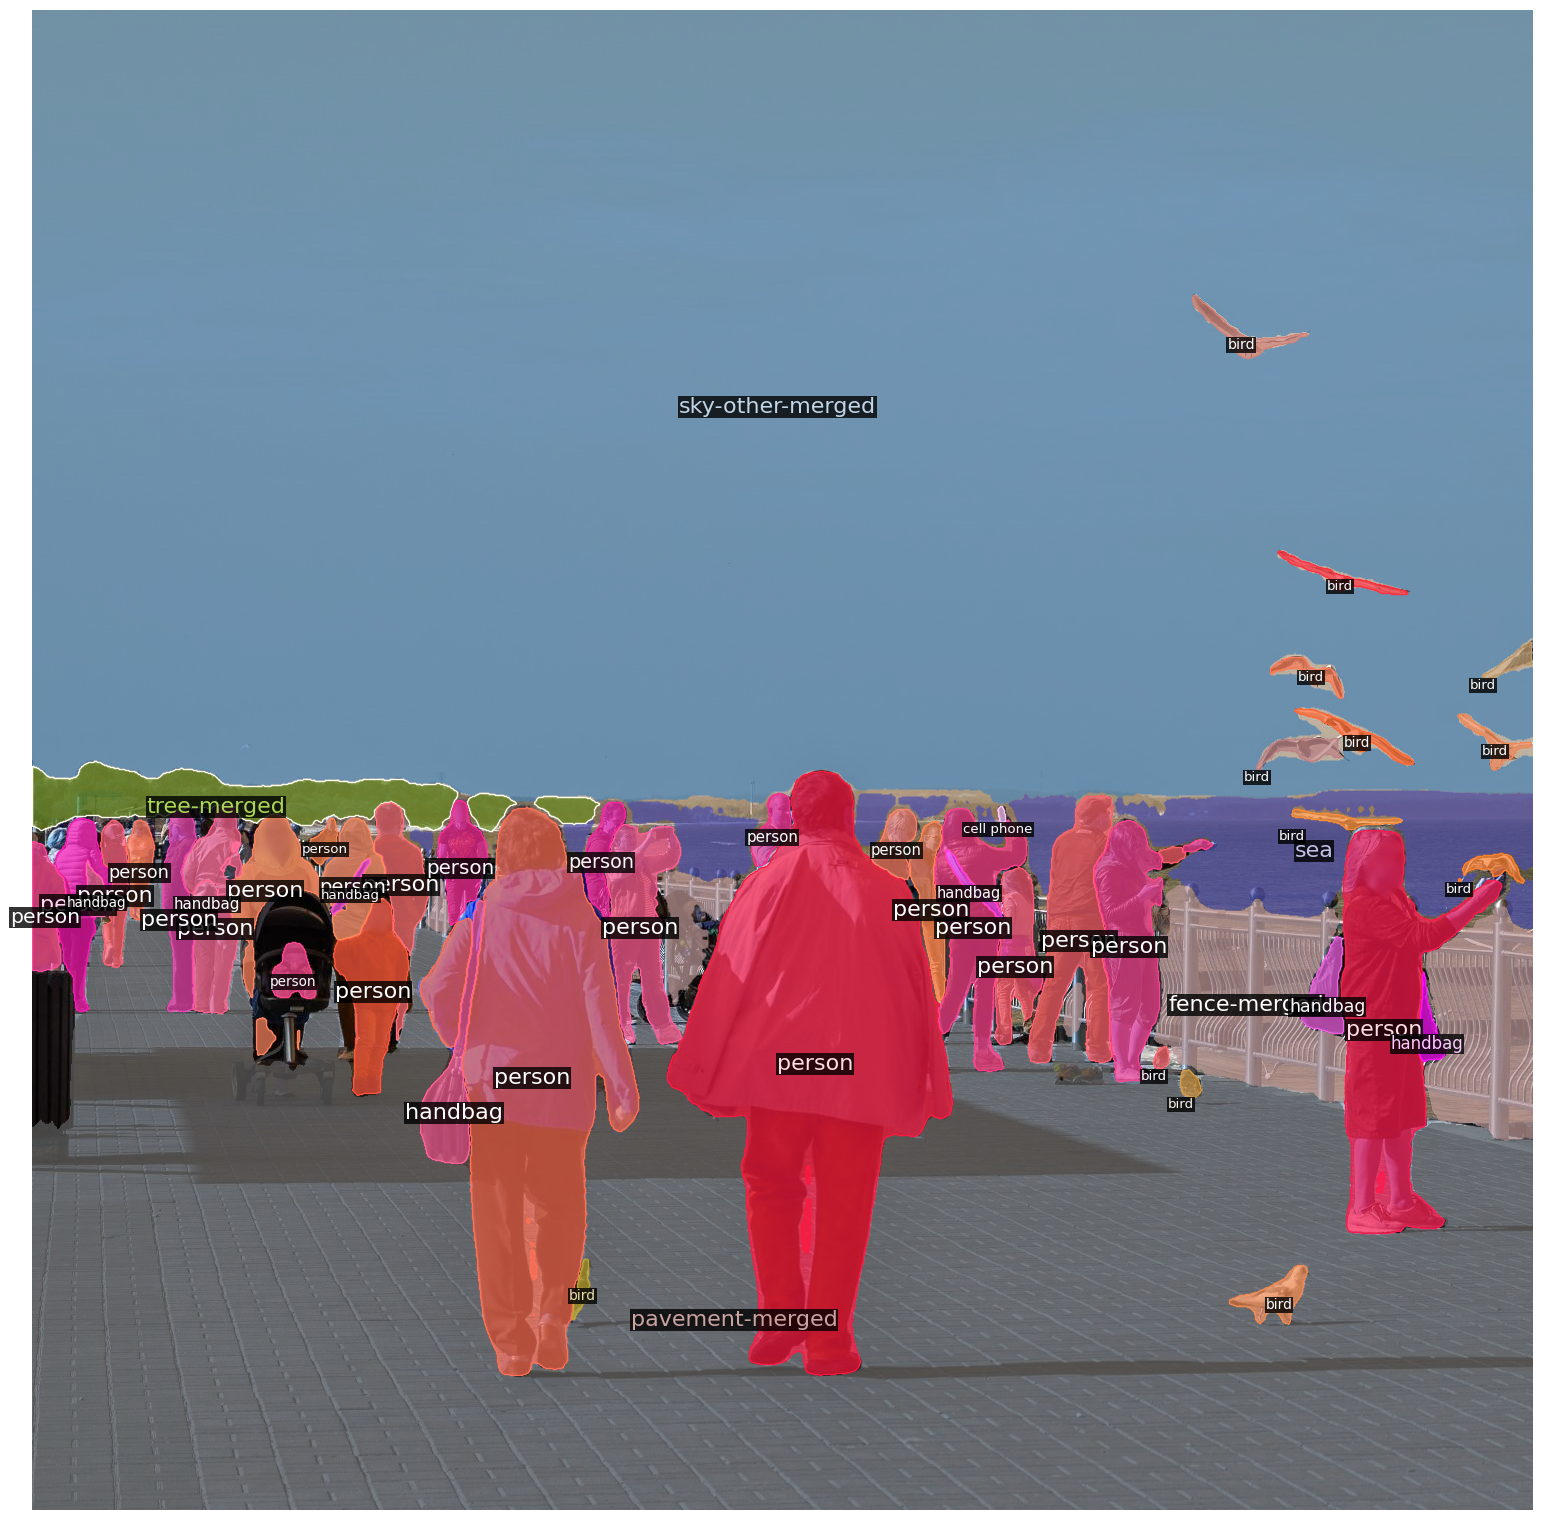

In [6]:
vis = Visualizer(img,metadata=metadata)
vis.draw_panoptic_seg(panoptic_seg.cpu(),segments_info)
display(vis.get_output().fig)
vis.get_output().save(os.path.join(ROOT,f'{fname}_pano.jpg'))

In [7]:
masks_vv,labels_vv = merge_part_and_pano(parts_seg_instance,parts_seg_instance_cls,panoptic_seg,test_args,segments_info)
cliped_parts = torch.clip(torch.sum(torch.stack(parts_seg_instance),dim=0),0,1)
labels_sam=[{'id':i+1,'name':k}for i,k in enumerate(labels_vv)]
input_sam = torch.stack(masks_vv)
new_input_sam =input_sam
new_labels_sam =labels_sam

masks_sam = mask_generator.generate(img)
mask_sam_stack = np.stack([x['segmentation'].astype(float) for x in masks_sam])
mask_sam_stack = torch.tensor(mask_sam_stack).float().to(new_input_sam)

sem_seg_with_bg = torch.cat([new_input_sam[0].unsqueeze(0)*0.0,
                            new_input_sam /( new_input_sam.sum(0,keepdims=True) + 1e-5)
                            ],dim=0)

bg_confidence = 0.05
sem_seg_with_bg[0] = bg_confidence
voting_output = vote(mask_sam_stack,sem_seg_with_bg,img.shape[:2])

idx_2_name = cat2ind_panoptics_coco(new_labels_sam)
mask_labels = voting_output['mask_labels'].cpu().numpy()
final_sam_masks = mask_sam_stack.cpu()

final_sam_masks = final_sam_masks[mask_labels>0]
mask_labels = mask_labels[mask_labels>0]
mask_labels_text = [idx_2_name[k] for k in mask_labels]
mask_labels_text = [x.split(',')[0] for x in mask_labels_text]

Length of coco_panoptic Categories : 163


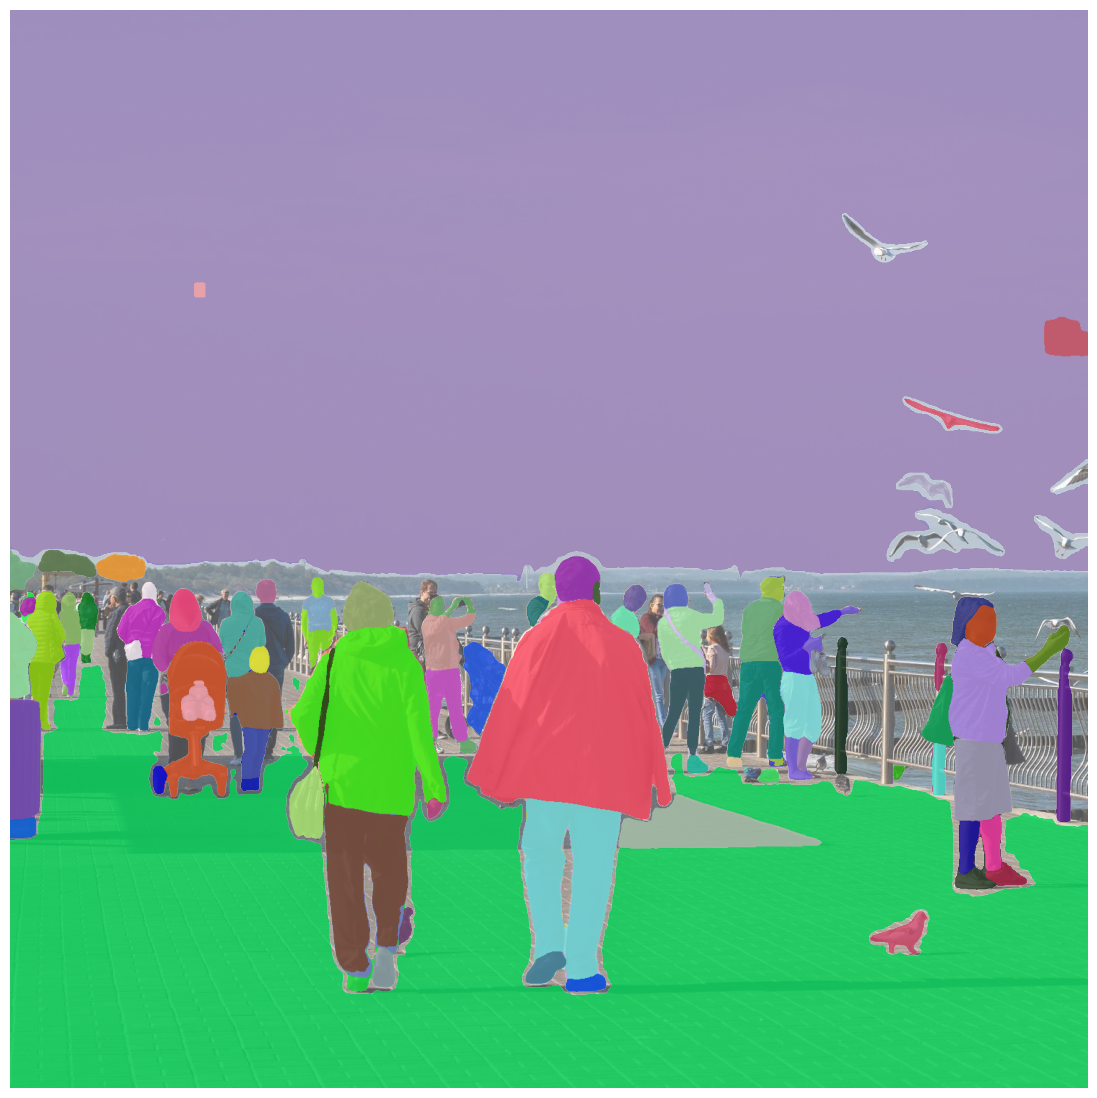

In [8]:
plt.figure(figsize=(14,14))
plt.imshow(img_rgb,alpha=0.7)
show_anns(masks_sam)
plt.axis('off')
plt.savefig(os.path.join(ROOT,fname+f'_sam.jpg'),bbox_inches='tight',pad_inches=0, dpi=600)
plt.show()
plt.close()

In [9]:
new_final_sam_masks =[]
new_mask_labels_text =[]
for m in range(len(final_sam_masks)):
    mask = final_sam_masks[m]
    overlap_ratio = (mask * cliped_parts).sum() / (mask.sum()+1e-9)
    if overlap_ratio<0.8:
        new_final_sam_masks.append(final_sam_masks[m])
        new_mask_labels_text.append(mask_labels_text[m])
new_final_sam_masks.extend(parts_seg_instance)
new_mask_labels_text.extend(parts_seg_instance_cls)
new_final_sam_masks = torch.stack(new_final_sam_masks)

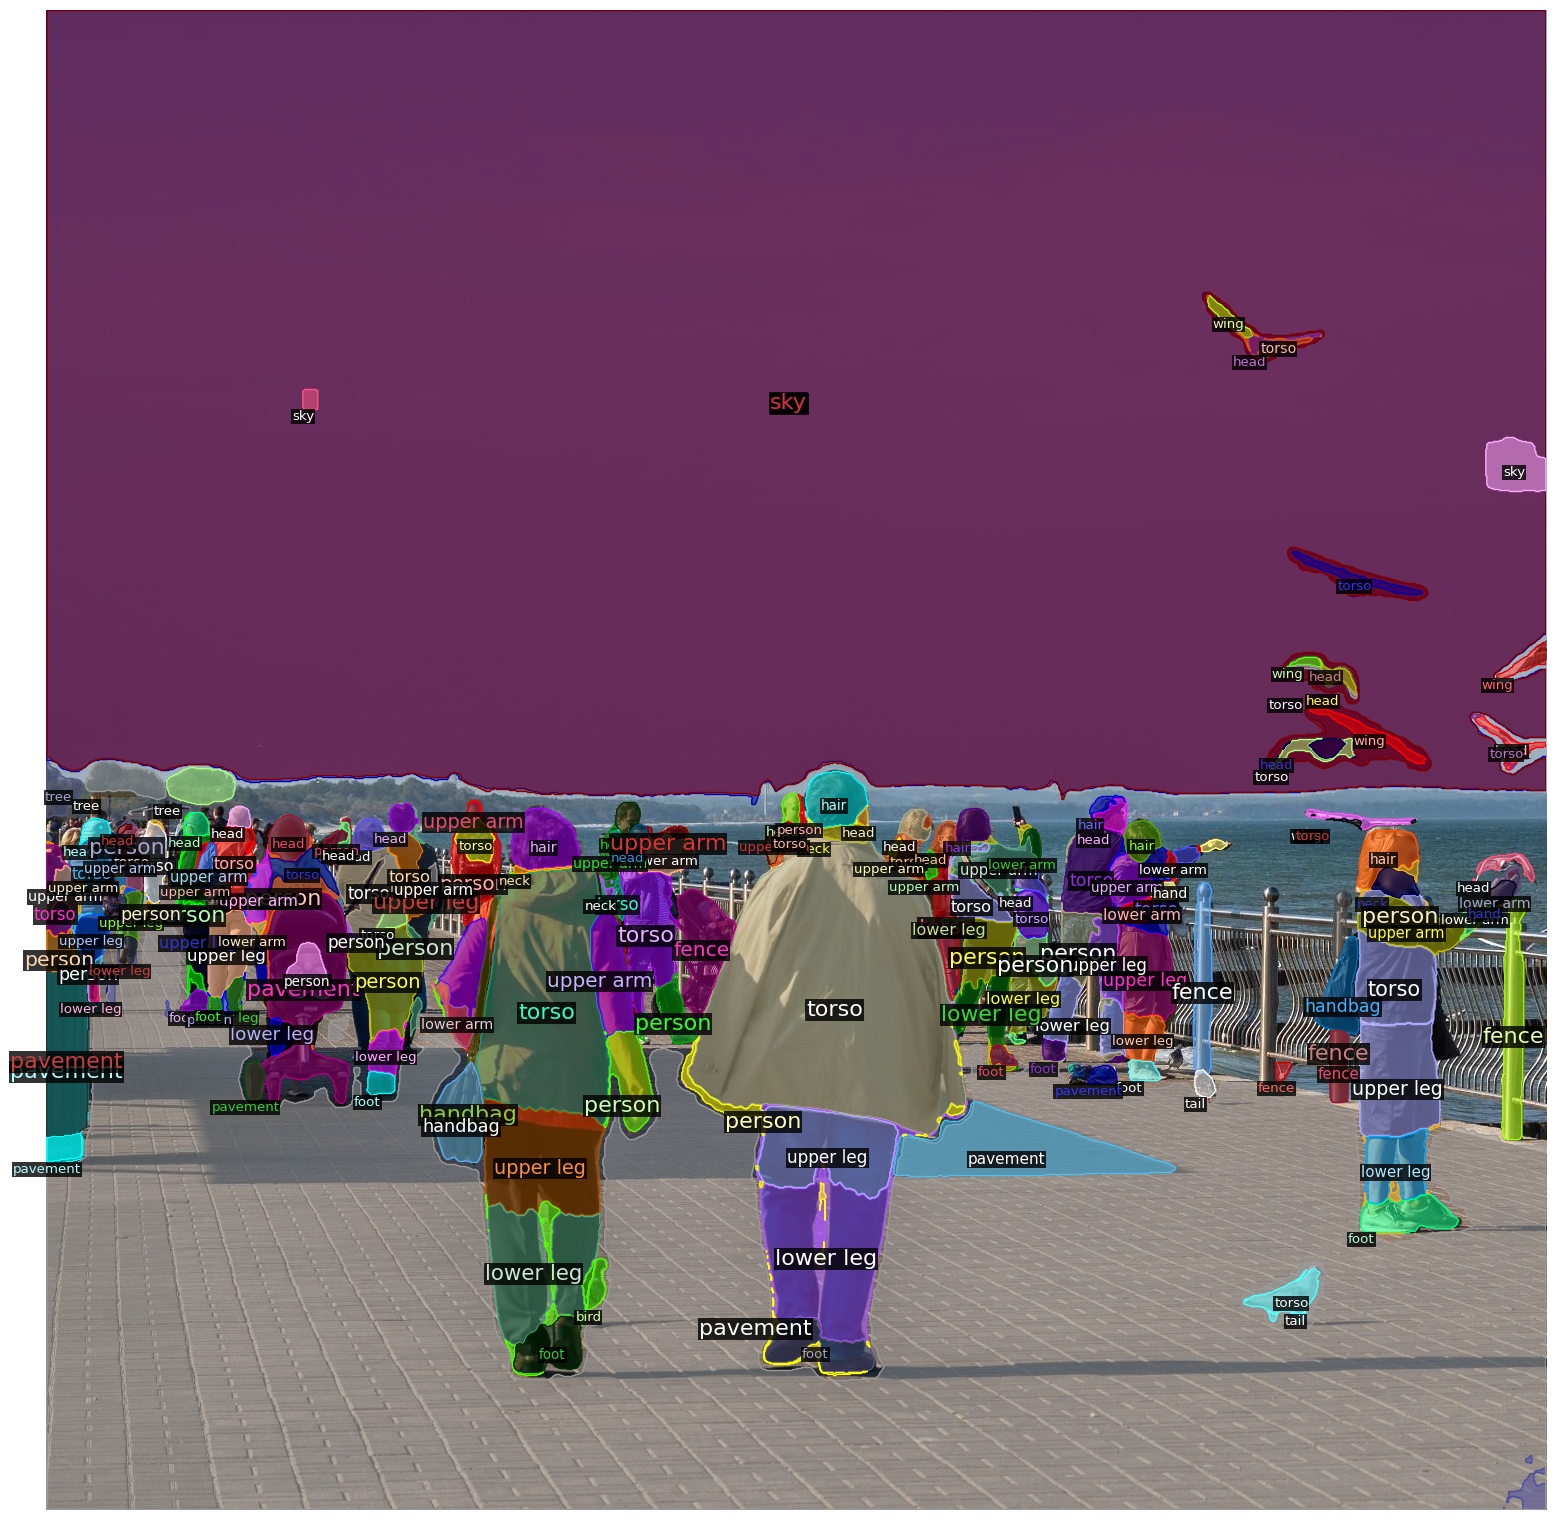

In [10]:
vis = Visualizer(img_rgb)
vis.overlay_instances(masks=new_final_sam_masks,labels=new_mask_labels_text)
vis.get_output().save(os.path.join(ROOT,f'{fname}_panpart.jpg'))
display(vis.get_output().fig)
image.save(os.path.join(ROOT,fname+f'_image.jpg'))